# Introduction

The previous version of the algorithm did not have sufficiently tight bounds. Hopefully this version will improve on this. We explain the algorithm, then implement it, step by step in the notebook below.

1) Consider the GP prediction as the sum of exponentiated quadratics centred on all the training points.
2) Split the world into hypercubes.
3) Consider one dimension d.
4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.
5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

6) We reintroduce the other dimensions of the hypercube. We can imagine the total change made to the predictions over the d-1 plane (of remaining dimensions) by moving a $d-1$ plane from one side of the hypercube to the other (along dimension d). This can be represented as a series of gaussians (EQs), each centred at one of the training points.

<pre>
d=2 example, n=3.        ------> sum of EQs   
                       |    .
                       |      .
      x                |       .  <-x
 ______________        |__   .
|              |  ,    |  .
|        o     | /|\   | .        <-o
|              |  |    |   .
|   x          |  |    |      .   <-x maximum within bounds of hypercube
|______________|  |z   |__   .
  ---------> d         |   .
                       |  .
                       | .

training points
x with weight = 1
o with weight = -1
</pre>

In the figure, imagine the distribution along the other axis (z) - it will be three EQs over one ($d-1$) dimensions. This sum will be the sum of three EQs (of d-1) dimensions centred at the locations of the training points (with the dth dimension removed).

7) We want to find the largest change possible in the prediction by moving along the d-axis, over the hypercube, both if we've stopped the integration somewhere within it, or if the integration was over the whole cube. Hence we needed the two results (from 4 and 5)...
8) We therefore will later be interested in the largest value in the $d-1$ space of this sum of gaussians. We will also be interested in the case in which the negative EQs are removed.

9) We next consider lists of hypercubes that one needs to pass through to get from the start to the end of dimension d. E.g. in this figure you need to pass through for example C, I, D and H. A full list of possible combinations will need to be made, e.g.:
<pre>
C I D H
C I D G
B D G
B D F
..etc

 ________________
|    |  |    |  |
| b  | d|    |H |
|   C|I | D  |_f|
|____|__|  e |G |
|   B c |    |__|
|_______|____|F |
|            |__|
xa   x  H    |E |
|____________|__|
0 1 2 3 4 5 6 7 8

Where A-I are the 9 hypercuboids, a-f are the peaks of the EQs.</pre>

10) For each list we need to consider all possible start and ends, for the first list the possible combinations are:
<pre>
C->C
C->I
C->D
C->H
I->I
I->D
..etc
</pre>
11) For each combination we then combine all the EQs from the hypercubes:
E.g. for the C->D list:

[$D^+$ EQs from <texttt>C</texttt>] + [$D^{all}$ EQs from <texttt>I</texttt>] + [$D^+$ EQs from <texttt>D</texttt>]


So the $D^+$ for hypercube C, would consist of:
- for a the difference between the minima and maxima of the value of a's EQ between 0 to 2.5 along a's other axes (i.e between the two bold xs)
- the same computation for b.

For the $D^{all}$ for hypercube I:
for point d we find the difference between the value of d's EQ at 2.5 and 4 (in the same axis in d's other dimensions).
As we're looking for the maximum possible change between a point in C to a point in D, we know that we must pass through the whole of I, hence why we include all the negative and positive gradient parts of the EQs.

12) We are left with a sum of EQs (all with the same lengthscales etc) but with different weights and locations (in a $d-1$ space), for each of the pairs of possible starts and ends.

13) For each of these sums. We want to find a bound on the maximum of this sum. (see other emails/module for this).

14) We find the maximum bound for each of the sums. And that is an upper bound on the largest change that can happen for any movement along the d axis.


So the first steps we need to do maths for is (4) and (5):

>    4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.

>    5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

### Two dimensional Demonstration

Here we place ten points randomly in the 5x5 square, of random weights (selected from the unit-normal distribution).

We compute the bound. Note that as we're only in 2d the algorithm doesn't compact to a lower-dim manifold so it gets to include the negative possible changes properly.

Above 3d the algorithm compacts to a lower dimensional manifold for speed in the grid search.

In [1]:
import numpy as np
np.set_printoptions(suppress=True,precision=2)
import matplotlib.pyplot as plt
%matplotlib inline
from GPAdversarialBound import compute_full_bound

#set up lengthscale, hypercubes, etc...
ls = 1.0
diff_dim = 0
dims = 2
cubesize = 5
EQcentres = np.random.rand(5,dims)*5
EQweights = np.random.randn(5)

In [2]:
bound, hypercube_starts, hypercube_ends, maxseg = compute_full_bound(EQcentres,EQweights,ls,diff_dim,dims,cubesize,splitcount=30)

In [3]:

print("Computed Bound: %0.2f.\n Corresponding to the path:" % bound)
print(maxseg)

Computed Bound: 2.10.
 Corresponding to the path:
[3, 5, 17, 24, 12, 30, 14]


Compare to a plot of the space. Hopefully it isn't possible to increase by more than the above bound, moving left-to-right within the box:

(-0.2, 6)

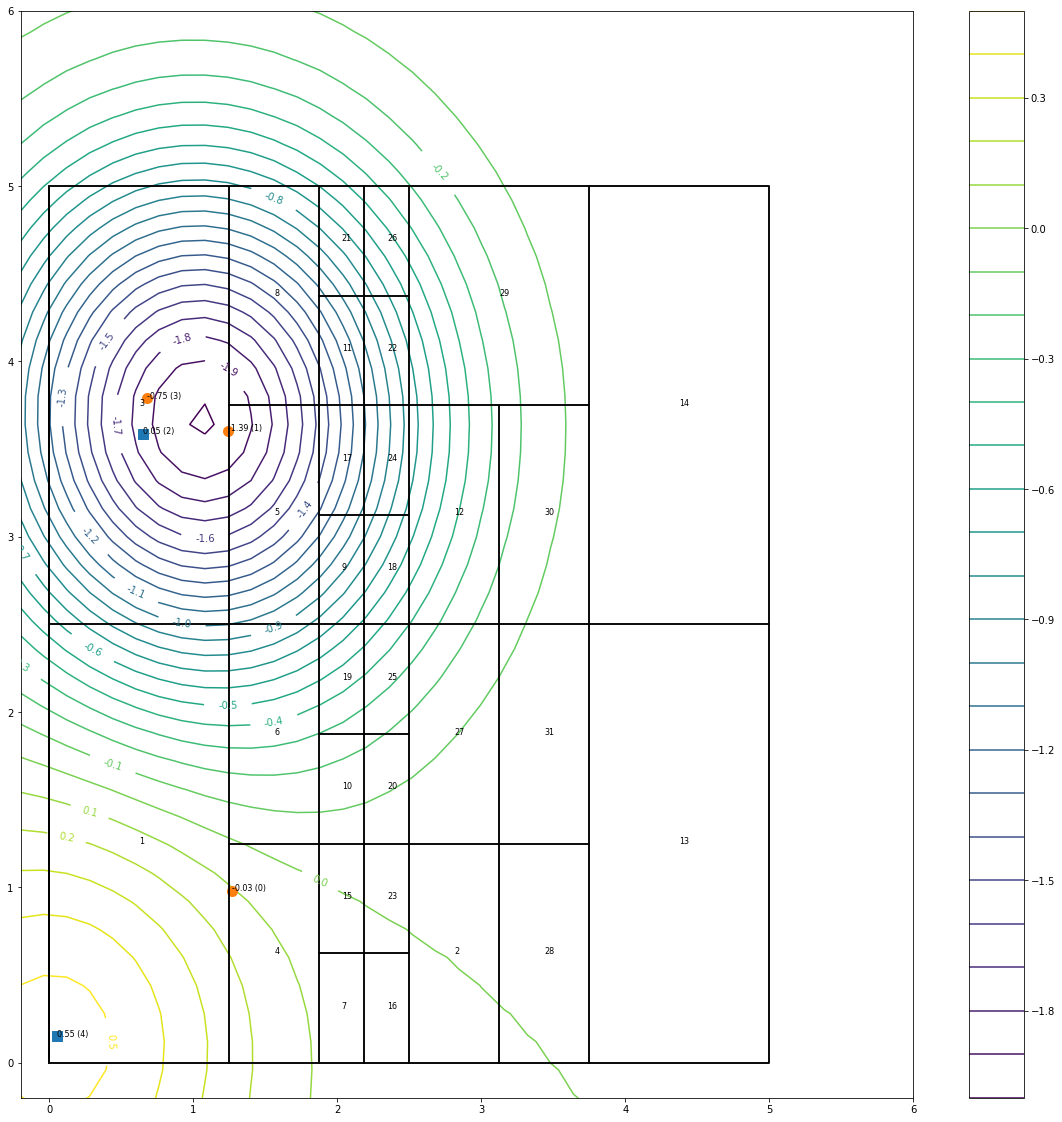

In [4]:
from boundmixofgaussians import zeromean_gaussian_1d, zeromean_gaussian, findbound, PCA

plt.figure(figsize=[20,20])
xs = np.arange(-1,10,0.16)
ys = np.arange(-1,10,0.16)
mg = np.array(np.meshgrid(xs,ys))
grid = np.array([mg[0].flatten(),mg[1].flatten()]).T
v = np.zeros([len(xs),len(ys)])
for eq,eqw in zip(EQcentres,EQweights):
    v += eqw*zeromean_gaussian(grid-eq,ls).reshape(len(xs),len(ys))
CS = plt.contour(xs,ys,v,levels=np.arange(-3,3,0.1))
plt.clabel(CS, inline=1, fontsize=10,fmt="%1.1f")
plt.colorbar()



plt.plot(EQcentres[EQweights>0,0],EQcentres[EQweights>0,1],'s',markersize=10,label='positive')
plt.plot(EQcentres[EQweights<0,0],EQcentres[EQweights<0,1],'o',markersize=10,label='negative')
for i, (c,w) in enumerate(zip(EQcentres,EQweights)):
    plt.text(c[0],c[1],"%0.2f (%d)"%(w,i),fontsize=8)
#plt.legend()

for idx, (hypercube_start, hypercube_end) in enumerate(zip(hypercube_starts,hypercube_ends)):
    plt.plot([hypercube_start[0],hypercube_start[0],hypercube_end[0],hypercube_end[0],hypercube_start[0]],[hypercube_start[1],hypercube_end[1],hypercube_end[1],hypercube_start[1],hypercube_start[1]],'k-')
    if idx>0: plt.text((hypercube_start[0]+hypercube_end[0])/2,(hypercube_start[1]+hypercube_end[1])/2,idx,fontsize=8)

plt.plot([0,0,5,5,0],[0,5,5,0,0],'k-')
plt.xlim([-.2,6])
plt.ylim([-.2,6])
